In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import torch.nn.functional as F

In [3]:
data=pd.read_csv('winequality-red.csv',sep=';')
data=data[data['total sulfur dioxide']<200]
X=data.drop('quality',axis=1)
y=data.quality
X=X.apply(stats.zscore)
y=y.to_frame()
data['boolQuality']=0
data.loc[data['quality']>5,'boolQuality']=1


In [4]:
Xt=torch.tensor(X.values).float()
yt=torch.tensor(data.boolQuality.values).float()
print(Xt.shape)
print(yt.shape)

torch.Size([1597, 11])
torch.Size([1597])


In [5]:
yt=yt[:,None]
yt.shape

torch.Size([1597, 1])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
Xt, yt, test_size=0.3, random_state=42)
train_data=TensorDataset(X_train,y_train)
test_data=TensorDataset(X_test,y_test)

train_loader=DataLoader(train_data,batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [11]:
class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input=nn.Linear(11,16)
        
        self.fc1=nn.Linear(16,32)
        self.bnorm1=nn.BatchNorm1d(16)
        self.fc2=nn.Linear(32,16)
        self.bnorm2=nn.BatchNorm1d(32)
        
        self.output=nn.Linear(16,1)
        
    def forward(self,x,doBN):
        x=F.relu(self.input(x))
        
        if doBN:
            x=self.bnorm1(x)
            x=self.fc1(x)
            x=F.relu(x)
            
            x=self.bnorm2(x)
            x=self.fc2(x)
            x=F.relu(x)
        else:
            x=F.relu(self.fc1(x))
            x=F.relu(self.fc2(x))
            
        return self.output(x)
            
         

In [12]:
numepochs=1000
def trainModel(doBN=True):
    lossfun=nn.BCEWithLogitsLoss()
    optimizer=torch.optim.SGD(ANNwine.parameters(),lr=0.01)
    trainAcc=[]
    testAcc=[]
    losses=[]
    for epochi in range(numepochs):
        ANNwine.train()
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=ANNwine(X,doBN)
            loss=lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
            batchLoss.append(loss.item())
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        X,y=next(iter(test_loader))
        ANNwine.eval()
        with torch.no_grad():
           
            
        
            testAcc.append(100*torch.mean(((ANNwine(X,doBN=True)>0)==y).float()).item())
        
    return trainAcc,testAcc,losses
            

In [13]:
ANNwine=ANNwine_withBNorm()
trainAcc,testAcc,losses=trainModel(True)


In [14]:
ANNwine=ANNwine_withBNorm()
trainAccNOBN,testAccNoBN,lossesNoBN=trainModel(False)


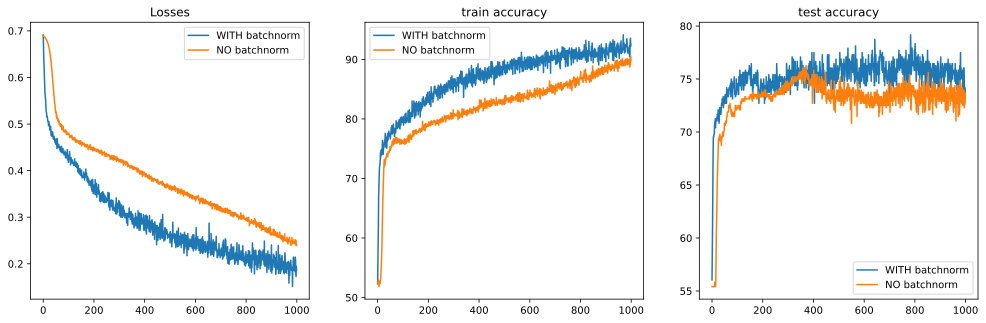

In [15]:
fig,ax=plt.subplots(1,3,figsize=(17,5))
ax[0].plot(losses,label='WITH batchnorm')
ax[0].plot(lossesNoBN,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAcc,label='WITH batchnorm')
ax[1].plot(trainAccNOBN,label='NO batchnorm')
ax[1].set_title('train accuracy')
ax[1].legend()

ax[2].plot(testAcc,label='WITH batchnorm')
ax[2].plot(testAccNoBN,label='NO batchnorm')
ax[2].set_title('test accuracy')
ax[2].legend()
